In this notebook, to determine whether Gini and Gamma can be used to detect changes in travel patterns as a policy application, I check how Gini and Gamma changes before and after Covid.

# Staging

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import calendar
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import fsolve

In [2]:
# Import station code and name mapper
df_stn = pd.read_csv('outputs/stn_data/others/stn_code_name.csv')

# Remove the three stations omitted in this study
stn_omit = ['Battersea Power Station', 'Heathrow Terminal 4 LU', 'Nine Elms']
df_stn = df_stn[~df_stn['stn_name'].isin(stn_omit)]

# List of unique station names
stn_name = sorted(list(set(df_stn['stn_name'])))

In [3]:
# Import operating hours mapper
df_time = pd.read_csv('outputs/stn_data/others/operating_hours.csv')

# Labels of slots
slots = ['slot_'+str(i) for i in df_time['timeslot']]
slots_plot = df_time['entrytime_start']

# Set of slots and number of slots
slots_set = set(df_time['timeslot'])
n_slots = len(slots_set)

In [4]:
# Cluster data
stations_cl_data = pd.read_csv('outputs/stn_data/features_and_cluster/stn_cluster.csv')
clusters = set(stations_cl_data['Cluster'])
n_cl = len(clusters)

cl_name = {}
for i in clusters:
    cl_name[i] = list(set(stations_cl_data.loc[stations_cl_data['Cluster'] == i,
                                               'Cluster_Name']))[0]

In [5]:
# Set color cycle and palette
col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
col_palette = {i+1: col_cycle[i] for i in range(n_cl)}
col_palette[3] = col_cycle[4]

In [6]:
sns.set(style="darkgrid")

# Functions for scalability

In [7]:
# Create function to import and prep data
def prep_data(period, stn_map, time_map):

    '''
    Import and prepare the TfL data for analysis

    :param period: list of month and year in study period
    :param stn_map: dataframe to map station codes to station names
    :param time_map: dataframe to map operating time to timeslots number
    :return df: dataframe of cleaned TfL data
    '''

    # --- STAGING --- #

    # Set last month and year in dataset
    last_mthyr = 'October2021'

    # Create mappers for data file to open
    # This is necessary because we convert calendar dates to operating dates
    period_map = {}

    yr_list = ['2020', '2021']
    mth_list = list(calendar.month_name)[1:]

    for i in range(len(yr_list)):
        for j in range(len(mth_list)):
            yr = yr_list[i]
            mth = mth_list[j]
            mth_yr = mth+yr
            if mth_yr == last_mthyr:
                break
            elif mth == 'December':
                period_map[mth_yr] = mth_list[0]+yr_list[i+1]
            else:
                period_map[mth_yr] = mth_list[j+1]+yr

    # Convert mappers for station codes to names, and for entry time to time slots
    code_name_map = {row['stn_code']: row['stn_name'] for index, row in stn_map.iterrows()}
    time_slot_map = {row['entrytime_start']: row['timeslot'] for index, row in time_map.iterrows()}
    date_change = list(time_map[time_map['shift_date'] == 1]['entrytime_start'])

    # List of bank holidays
    holidays = ['01/01/2020', '10/04/2020', '13/04/2020',
                '04/05/2020', '08/05/2020', '25/05/2020',
                '31/08/2020', '25/12/2020', '28/12/2020',
                '01/01/2021', '02/04/2021', '05/04/2021',
                '03/05/2021', '31/05/2021',
                '30/08/2021', '27/12/2021', '28/12/2021']
    holidays=[datetime.strptime(date, '%d/%m/%Y')\
              .date() for date in holidays]

    # Days of week
    days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                    'Saturday', 'Sunday']
    days_mapper = dict(zip(range(0,7), days_of_week))

    # Columns to open
    col_open = ['CalendarDate', 'EntryTime',
                'EntryStationName', 'EntryLocationId',
                'ExitStationName', 'ExitLocationId',
                'AvgTT', 'NumberOfJourneys']


    # --- READ DATA --- #

    for current_mthyr in period:

        print(f'READING: {current_mthyr.upper()}')

        # Import data for current month and year
        filepath = 'data/tfl_data/'+current_mthyr+'_Compiled.csv'
        df_temp = pd.read_csv(filepath,
                              usecols = col_open)

        # If current month and year is not last month in data period
        if (current_mthyr!=last_mthyr):
            # If next month and year is not in study period
            next_mthyr = period_map[current_mthyr]
            if next_mthyr not in period:
                print(f'Checking {next_mthyr}')
                # Import data for next month and year
                filepath = 'data/tfl_data/'+next_mthyr+'_Compiled.csv'
                df_next = pd.read_csv(filepath,
                                      usecols = col_open)
                # Keep only data falling on the first of the next month and year
                df_next = df_next[df_next['CalendarDate'].str[:2] == '01']
                # Concatenate data for the month
                df_temp = pd.concat([df_temp, df_next], ignore_index=True)


        # --- CLEAN STATIONS --- #

        print('Cleaning stations')

        # Keep only records originating or ending on LU
        df_temp = df_temp[(df_temp['EntryLocationId'].isin(stn_map['stn_code'])) |\
                          (df_temp['ExitLocationId'].isin(stn_map['stn_code']))]

        # Map name of stations
        for ent_ex in ['Entry', 'Exit']:
            df_temp[ent_ex+'StationName'] = df_temp[ent_ex+'LocationId'].map(code_name_map)

        df_temp.fillna(value='Non-LU', inplace=True)

        # Remove journeys that start and end at same station
        df_temp = df_temp[df_temp['EntryStationName'] != df_temp['ExitStationName']]

        # --- CLEAN DATE AND TIME --- #

        print('Cleaning date and time \n')

        # Keep only records with entry time within operating hours and get their timeslots
        df_temp['EntryTime_Start'] = df_temp['EntryTime'].str[:5]
        df_temp = df_temp[df_temp['EntryTime_Start'].isin(df_time['entrytime_start'])]
        df_temp['EntryTimeslot'] = df_temp['EntryTime_Start'].map(time_slot_map)
        
        # Get exit timeslot
        df_temp['NumTimeslots'] = df_temp['AvgTT']/60/15
        df_temp['NumTimeslots'] = df_temp['NumTimeslots']\
            .apply(np.ceil, axis=1).astype(int)
        df_temp['ExitTimeslot'] = df_temp['EntryTimeslot'] +\
            df_temp['NumTimeslots']

        # Convert to datetime format
        df_temp['EntryDate_dt'] = pd.to_datetime(df_temp['CalendarDate'], format='%d/%m/%Y')

        # Get operating date
        df_temp['OperatingDate_dt'] = pd.to_datetime(df_temp['CalendarDate'], format='%d/%m/%Y')
        idx = df_temp[df_temp['EntryTime_Start'].isin(date_change)].index
        df_temp.loc[idx, 'OperatingDate_dt'] = df_temp.loc[idx, 'OperatingDate_dt']-timedelta(days=1)

        # Keep only records with operating data within study period
        op_mth_year = df_temp['OperatingDate_dt'].dt.month_name() + \
            df_temp['OperatingDate_dt'].dt.year.astype(str)
        df_temp = df_temp[op_mth_year.isin(period)]

        # Remove bank holidays
        df_temp = df_temp[~df_temp['OperatingDate_dt'].isin(holidays)]

        # Get operating day
        df_temp['OperatingDay_dt'] = df_temp['OperatingDate_dt'].dt.dayofweek
        df_temp['OperatingDay'] = df_temp['OperatingDay_dt'].map(days_mapper)
        
        df_temp['OperatingDate_mthyr'] = \
            df_temp['OperatingDate_dt'].dt.month_name() +\
            df_temp['OperatingDate_dt'].dt.year.astype(str)

        # --- CONCATENATE DATA --- #
        if current_mthyr == period[0]:
            df = df_temp.copy()
        else:
            df = pd.concat([df,df_temp], ignore_index=True)

    print('DONE!')

    return df

In [8]:
# Create function to generate time series data for individual stations
def stn_time_series(df, entex, stn_name, slots):
    
    '''
    Generate time series data where rows are the stations,
    columns are the timeslot, and values are the average number
    of journeys

    :param df: dataframe of data on number of journeys
    :param entex: choice of entry or exit; ['Entry', 'Exit']
    :param stn_name: list of station names
    :param slots: list of timeslots
    :return ts: time series dataframe
    '''

    df_func = df.copy()
    
    # Set up entry or exit
    stn_col = entex + 'StationName'
    slot_col = entex + 'Timeslot'
    
    # If exit, remove timeslots outside operating hours
    if entex == 'Exit':
        slots_list = [int(slot[5:]) for slot in slots]
        df_func = df_func[df_func[slot_col].isin(slots_list)]
    
    # Aggregate dataframe by entry station names, operating date, and timeslot,
    # then sum all the journeys
    ts_agg = df_func.groupby([stn_col, 'OperatingDate_dt', slot_col])\
        .agg({'NumberOfJourneys': 'sum'}).reset_index()

    # Get number of operating dates
    n_op_dates = len(set(ts_agg['OperatingDate_dt']))

    # Pivot table to find average number of journeys for each station (row)
    # in each timeslot
    ts = ts_agg.pivot_table(index=stn_col, columns=slot_col,
                            values='NumberOfJourneys', aggfunc='sum')
    ts = ts / n_op_dates
    ts.columns = ['slot_'+str(i) for i in ts.columns]
    ts.fillna(0, inplace=True)
    
    # Drop non-LU stations
    ts.drop(index='Non-LU', inplace=True)

    # If there are missing stations
    if ts.shape[0] != len(stn_name):
        # Find missing station
        missing_stn = list(set(stn_name) - set(ts.index))
        # Append rows of zeros
        ts = ts.append(pd.DataFrame(0, index=missing_stn, columns = ts.columns))

    # If there are missing time slots
    if ts.shape[1] != len(slots):
        # Find missing timeslots
        missing_slots = sorted(list(set(slots) - set(ts.columns)))
        # Insert columns of zeros in position
        for j in missing_slots:
            # Find position of columns to insert
            loc = int(j.split('_')[1])-1
            ts.insert(loc, j, [0]*ts.shape[0])

    return ts

In [9]:
# Create function to generate equation to tune alpha

def func(x, wt_list, wt_sum):

    '''
    Generate the callable equation to tune alpha for either
    simple exponential smoohting or negative power weighting method
    using fsolve function in scipy.

    :param x: variable for alpha
    :param wt_list: list of weights
    :param wt_sum: sum of weights
    :return: Callable function
    '''

    # Generate eqn
    eqn = ' + '.join(wt_list) + wt_sum

    return eval(eqn)

In [10]:
# Create function to generate temporal weight matrix

def temporal_wt_matrix(df, n_nb, wt_mtd):

    '''
    Compute the temporal weight matrix for a time series,
    based on the number of neighbours and weight assignment method
    chosen by user.

    :param df: the time series data
    :param n_nb: number of neighbours
    :param wt_mth: method to assigning weights; ['indicator', 'ses', 'neg_pow' or 'neg_exp']
    :return: list of temporally lagged values
    '''

    # Need to import math here again because of 
    # issues with using 'eval' in local scope
    import math

    # Initialize dataframe to hold temporal weight matrix
    wt_matrix = {}

    # Get length of time series,
    # check whether length is odd or even, 
    # and get midpoint
    T = len(df)
    odd_even = T%2   # odd if 1, even if 0
    if odd_even == 1:
        midpoint = math.ceil(T/2)
    else:
        midpoint = math.floor(T/2)

    # Get slot names
    slot_idx = df.index

    # Set sum of weights and del_t
    if wt_mtd == 'indicator':
        wt_sum = -1
        del_t = None
    if wt_mtd == 'ses':
        wt_sum = -0.999
        del_t = None
    if wt_mtd == 'neg_pow' or wt_mtd == 'neg_exp':
        wt_sum = -1
        del_t = 15

    # Solve for value of alpha first
    if wt_mtd == 'indicator':
        base_eqn = ['x' for j in range(T)]
    if wt_mtd == 'ses':
        base_eqn = ['x*(1-x)**'+str(j) for j in range(T)]
    if wt_mtd == 'neg_pow':
        base_eqn = ['(' + str(j+1) + '*' + str(del_t) + ')**(-x)'
                    for j in range(T)]
    if wt_mtd == 'neg_exp':
        base_eqn = ['math.exp(-x*' + str(j+1) + '*' + str(del_t) + ')'
                    for j in range(T)]

    x = fsolve(func, [wt_sum/T],
               args=(base_eqn, str(wt_sum)))[0]

    # For observations of interest i up to mid-point
    for i in range(1, midpoint+1):

        # Get number of weights on the right
        last_wt = min(n_nb, T-i)

        # Generate right half of weights
        if wt_mtd == 'indicator':
            right_wt = ['x' for j in range(last_wt)]
        if wt_mtd == 'ses':
            right_wt = ['x*(1-x)**'+str(j) for j in range(last_wt)]
        if wt_mtd == 'neg_pow':
            right_wt = ['(' + str(j+1) + '*' + str(del_t) + ')**(-x)'
                        for j in range(last_wt)]
        if wt_mtd == 'neg_exp':
            right_wt = ['math.exp(-x*' + str(j+1) + '*' + str(del_t) + ')'
                        for j in range(last_wt)]

        # Add trailing zeros in right half of weight list
        right_wt = right_wt + ['0']*(T-i-n_nb)

        # Generate entire weight list
        wt_matrix[slot_idx[i-1]] = right_wt[0:i-1][::-1] + ['0'] + right_wt

    # Compute weights
    scope = locals()
    for k, v in wt_matrix.items():
        wt_list = [eval(j, scope) for j in v]
        if n_nb != 0:
            wt_matrix[k] = [j/sum(wt_list) for j in wt_list]
        else:
            wt_matrix[k] = wt_list

    # For remaining observations of interest i
    for i in range(midpoint+1, T+1):
        # Get 'index' of mirror observation
        mirror = (T-i)+1
        wt_matrix[slot_idx[i-1]] = wt_matrix[slot_idx[mirror-1]][::-1]

    return wt_matrix

In [11]:
# Create function to compute temporally lagged values

def temporal_lagged(df, wt_matrix):

    '''
    Compute the temporally lagged values for a time series.

    :param df: the time series data
    :param wt_matrix: dictionary of weight matrix
    :return: list of temporally lagged values
    '''

    # Compute temporally lagged variable
    temp_lagged = [sum(df['Y']*wt_matrix[slot]) for slot in df.index]

    return temp_lagged

In [12]:
# Create function to compute Gini

def gini(df, var_type):

    '''
    Compute the Gini index for the entries. 
    Works for both original time series data and temporally lagged data

    :param df: the time series data
    :param var_type: whether it is for original values or temporally lagged values, ['Y', 'WY']
    :return: Gini index
    '''

    # Sort time slot in ascending order by value
    df_sorted = df.sort_values(var_type)

    # Add a column on the cumulative distribution function of rank, F
    n_slots = len(df_sorted)
    df_sorted['F'] = np.array(range(1, n_slots+1)) / n_slots

    # Compute Gini index
    covar = df_sorted.cov().loc['Y', 'F']
    gini_stn = 2*covar/df_sorted['Y'].mean()

    return gini_stn

In [13]:
# Create function to compute Gini and gamma for all stations

def conc(df, n_nb, wt_mtd):

    '''
    Compute G, temporally re-ranked G, and gamma for all stations

    :param df: the time series data
    :param n_nb: number of neighbours for computing temporal lag values
    :param wt_mtd: weight assignment method for computing temporal lag values
    :return: df of G, G_T and gamma
    '''

    df_func = df.copy()

    # Create list to hold values
    G_list = []
    G_T_list = []

    # Loop through all stations    
    for stn in df_func.index:

        # Get time series of station
        ts_stn = df_func.loc[df_func.index == stn].T
        ts_stn.columns = ['Y']

        # Compute Gini
        G_list.append(gini(ts_stn, 'Y'))

        # Get weight matrix if first station
        # Otherwise, can use the same matrix
        if stn == df_func.index[0]:
            wt_matrix = temporal_wt_matrix(ts_stn.copy(),
                                           n_nb,
                                           wt_mtd=wt_mtd)

        # Compute temporally lagged values and temporally re-ranked Gini
        ts_stn['WY'] = temporal_lagged(ts_stn.copy(), wt_matrix)
        G_T_list.append(gini(ts_stn, 'WY'))

    gamma_list = [G_T_stn/G_stn for G_T_stn, G_stn in zip(G_T_list, G_list)]

    df_gamma = pd.DataFrame(zip(df_func.index, G_list, G_T_list, gamma_list),
                            columns=[df_func.index.name, 'G', 'G_T', 'gamma'])

    return df_gamma

In [14]:
h = 6
wt_mtd = 'indicator'

In [15]:
weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']

# Compare Pre- and Post-Covid

## Compute Gini and Gamma

In [16]:
# Pre-Covid
pre_period = ['January2020',
              'February2020']

# Get data
df_pre = prep_data(pre_period, df_stn, df_time)
df_pre_sub = df_pre[df_pre['OperatingDay'].isin(weekdays)]

# Generate time series dataframe of average counts
pre_entry = stn_time_series(df_pre_sub, 'Entry', stn_name, slots)
pre_exit = stn_time_series(df_pre_sub, 'Exit', stn_name, slots)

# Sum entries and exits
pre_throughput = pre_entry.copy() + pre_exit.copy()
pre_throughput.index.name = 'StationName'

# Compute concentration
pre_throughput_conc = conc(pre_throughput, h, wt_mtd)

READING: JANUARY2020
Cleaning stations
Cleaning date and time 

READING: FEBRUARY2020
Checking March2020
Cleaning stations
Cleaning date and time 

DONE!


In [17]:
# Post-Covid
post_period = ['May2021',
               'June2021',
               'July2021',
               'August2021']

# Get data
df_post = prep_data(post_period, df_stn, df_time)
df_post_sub = df_post[df_post['OperatingDay'].isin(weekdays)]

# Generate time series dataframe of average counts
post_entry = stn_time_series(df_post_sub, 'Entry', stn_name, slots)
post_exit = stn_time_series(df_post_sub, 'Exit', stn_name, slots)

# Sum entries and exits
post_throughput = post_entry.copy() + post_exit.copy()
post_throughput.index.name = 'StationName'

# Compute concentration
post_throughput_conc = conc(post_throughput, h, wt_mtd)

READING: MAY2021
Cleaning stations
Cleaning date and time 

READING: JUNE2021
Cleaning stations
Cleaning date and time 

READING: JULY2021
Cleaning stations
Cleaning date and time 

READING: AUGUST2021
Checking September2021
Cleaning stations
Cleaning date and time 

DONE!


In [18]:
# Range standardize demand data for plotting purpose

# Define helper function
def MinMax_Std(df):

    df_std = df.copy()
    df_std = df_std.subtract(df_std.min(axis=1), axis=0)\
        .divide(df_std.max(axis=1) - df_std.min(axis=1), axis=0)\
        .combine_first(df_std)

    return df_std


# Standardize data
pre_throughput_std = MinMax_Std(pre_throughput)
post_throughput_std = MinMax_Std(post_throughput)

pre_throughput_std.columns = slots_plot.values
post_throughput_std.columns = slots_plot.values

## Compute percentage change

In [19]:
# Compute change in gini
gini_change = (post_throughput_conc['G'] - pre_throughput_conc['G'])/\
    pre_throughput_conc['G']*100

In [20]:
# Compute change in gamma
gamma_change = (post_throughput_conc['gamma'] - pre_throughput_conc['gamma'])/\
    pre_throughput_conc['gamma']*100

In [21]:
# Create dataframe
covid_change = pd.DataFrame(zip(stn_name, gini_change, gamma_change),
                            columns=['StationName', 'gini_change', 'gamma_change'])

In [22]:
# Merge cluster data
covid_change = pd.merge(covid_change, stations_cl_data,
                        on='StationName')

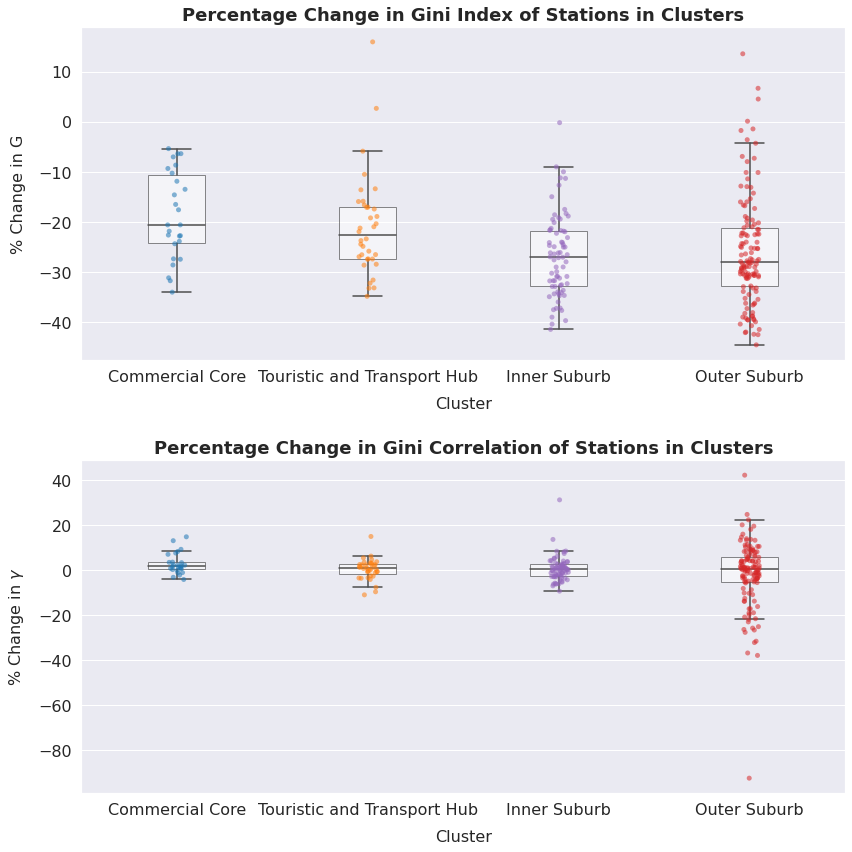

In [23]:
# Plot percentage change in gini and gamma
fig, ax = plt.subplots(2, figsize=(12, 12))

# Plot change in Gini
sns.stripplot(data=covid_change, x='Cluster', y='gini_change',
              palette=col_palette.values(), ax=ax[0],
              alpha=0.55, jitter=0.05)
sns.boxplot(data=covid_change, x='Cluster', y='gini_change',
            ax=ax[0],
            width=0.3,
            boxprops=dict(linewidth=1, facecolor='w', edgecolor='k', alpha=0.5),
            showfliers=False)

# Plot change in Gamma
sns.stripplot(data=covid_change, x='Cluster', y='gamma_change',
              palette=col_palette.values(), ax=ax[1],
              alpha=0.55, jitter=0.05)
sns.boxplot(data=covid_change, x='Cluster', y='gamma_change',
            ax=ax[1],
            width=0.3,
            boxprops=dict(linewidth=1, facecolor='w', edgecolor='k', alpha=0.5),
            showfliers=False)

# Formatting
for ax_id in [0, 1]:
    ax[ax_id].set_xlabel('Cluster', fontsize=16, labelpad=12)
    ax[ax_id].set_xticklabels(cl_name.values(), size=16)
    ax[ax_id].tick_params(labelsize=16);

ax[0].set_title("Percentage Change in Gini Index of Stations in Clusters",
                fontsize=18, weight='bold')
ax[0].set_ylabel("% Change in G", fontsize=16, labelpad=12)

ax[1].set_title("Percentage Change in Gini Correlation of Stations in Clusters",
                fontsize=18, weight='bold')
ax[1].set_ylabel(r"% Change in $\gamma$", fontsize=16, labelpad=12)

fig.tight_layout()
plt.subplots_adjust(hspace=0.3)

#fig.savefig('outputs/figures/covid/covid_change.png', bbox_inches="tight")

In [24]:
print(f"Number of stations with a decrease in gamma: {len(covid_change[gamma_change>0])}")

Number of stations with a decrease in gamma: 148


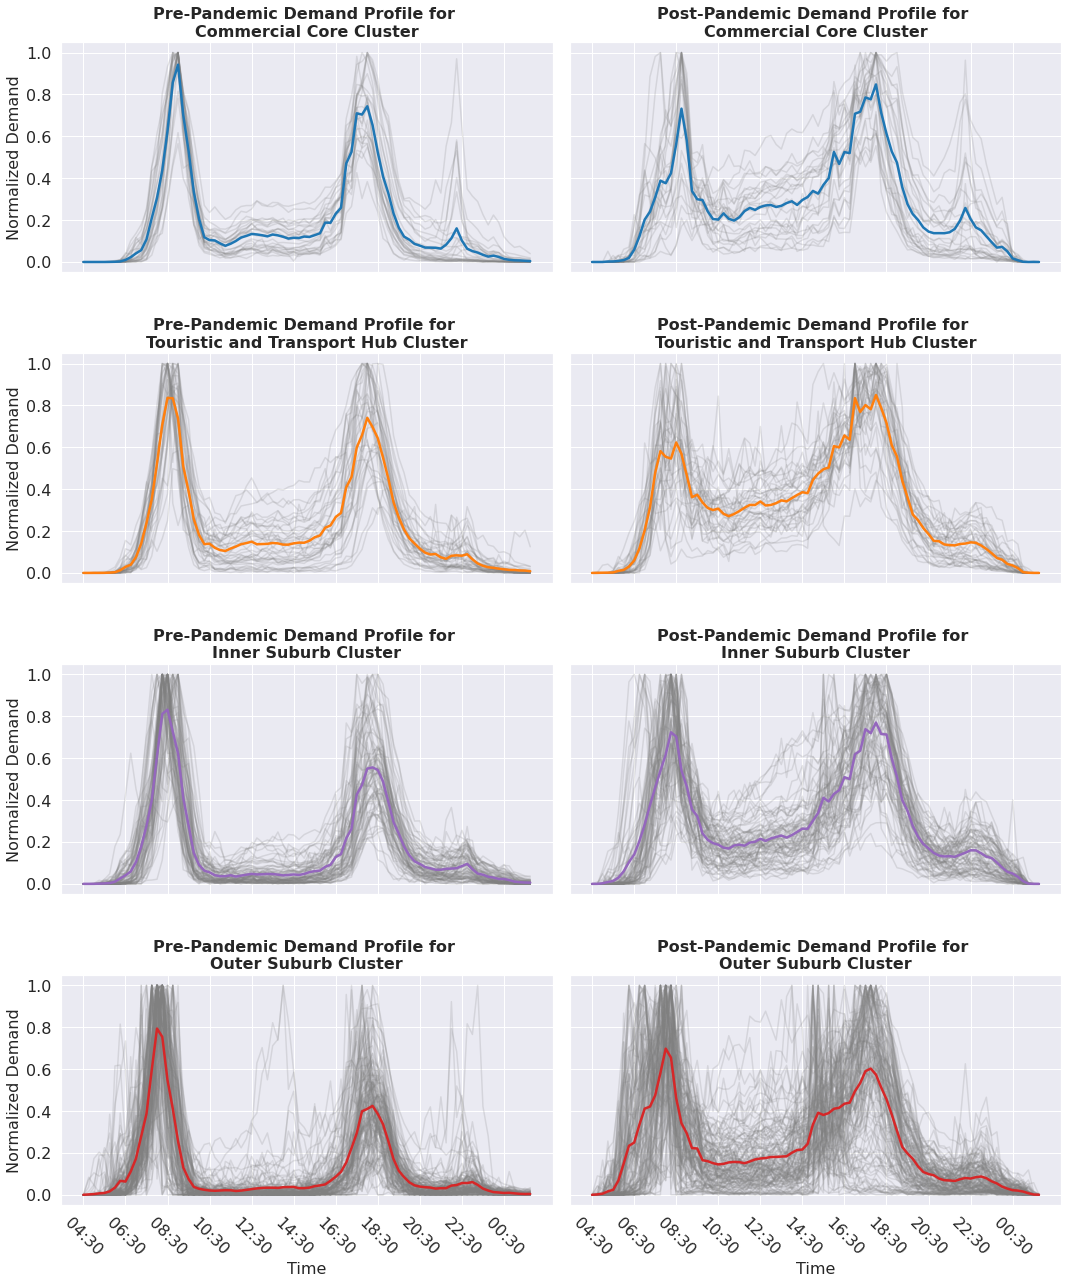

In [25]:
# Plot change in demand profile
fig, ax = plt.subplots(n_cl, 2, figsize=(15, 4.5*n_cl),
                       sharex='col', sharey='row')

ax_map = {'pre': 0, 'post': 1}

for cl in clusters:

    ax_y = cl-1

    for pre_post in ['pre', 'post']:

        ax_x = ax_map[pre_post]

        # Get datapoint
        data_plot = globals()[pre_post+'_throughput_std']

        # Get stations
        stns = stations_cl_data[stations_cl_data['Cluster']==cl]['StationName']
        data_plot = data_plot[data_plot.index.isin(stns)]

        # Plot station data
        ax[ax_y, ax_x].plot(data_plot.T.index, data_plot.T, c="gray", alpha=0.2);
        ax[ax_y, ax_x].plot(data_plot.T.index, data_plot.mean(),
                            c=col_palette[cl], linewidth=2.5);

        # Formatting
        ax[ax_y, ax_x].set_title(f"{pre_post.capitalize()}-Pandemic Demand Profile for \n{cl_name[cl]} Cluster",
                                 fontsize=16, weight='bold')
        ax[ax_y, ax_x].set_xticks(range(0, len(data_plot.columns), 8));
        ax[ax_y, ax_x].tick_params(axis='x', rotation=315);
        ax[ax_y, ax_x].tick_params(axis='x', labelsize=16);

for j in [0, 1]:
    ax[n_cl-1, j].set_xlabel('Time', size=16)

for k in range(n_cl):
    ax[k, 0].set_ylabel('Normalized Demand', size=16)
    ax[k, 0].tick_params(axis='y', labelsize=16);
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.35)

#fig.savefig('outputs/figures/covid/covid_demand_profile.png',
#            bbox_inches="tight")

In [26]:
# Find percentage change in each segment of the day, based on peak and off-peak hours by TfL
am_offpeak = ['slot_'+str(i) for i in range(1,9)]
am_peak = ['slot_'+str(i) for i in range(9,21)]
mid_offpeak = ['slot_'+str(i) for i in range(21,47)]
pm_peak = ['slot_'+str(i) for i in range(47,59)]
pm_offpeak = ['slot_'+str(i) for i in range(59,87)]

period_of_day = ['am_offpeak', 'am_peak', 'mid_offpeak', 'pm_peak', 'pm_offpeak']

In [27]:
# Create lists to hold values
for i in period_of_day:
    globals()['pre_'+i] = []
    globals()['post_'+i] = []
    globals()['change_'+i] = []

In [28]:
# Compute change
for cl in clusters:

    # Get stations in cluster
    stns = stations_cl_data[stations_cl_data['Cluster']==cl]['StationName']
    
    # Get demand data
    pre_demand = pre_throughput.loc[stns]
    post_demand = post_throughput.loc[stns]

    # For each period
    for i in period_of_day:
        # Segment data
        pre_demand_sub = pre_demand.loc[:, globals()[i]].sum(axis=1)
        post_demand_sub = post_demand.loc[:, globals()[i]].sum(axis=1)
        # Compute change
        change_demand_sub = (post_demand_sub-pre_demand_sub)/pre_demand_sub
        # Drop infinity
        change_demand_sub = change_demand_sub.replace([np.inf],np.nan).dropna()
        # Compute mean percentage change
        globals()['change_'+i].append(change_demand_sub.mean()*100)

In [29]:
# Create dataframe
percent_change = pd.DataFrame(zip(clusters, change_am_offpeak, change_am_peak,
                                  change_mid_offpeak, change_pm_peak, change_pm_offpeak),
                              columns=['cluster']+period_of_day)

In [30]:
percent_change

,cluster,am_offpeak,am_peak,mid_offpeak,pm_peak,pm_offpeak
0,1,708.264602,-75.138441,-41.604166,-59.471031,-39.773774
1,2,231.125560,-44.350733,59.186409,-15.210884,-17.207852
2,3,453.920468,-36.286799,219.111172,9.753852,1.018710
3,4,934.278459,53.439641,1790.078479,131.373665,117.323754
